# Function 1 - Identifying Radiation Sources


In [44]:
import pandas as pd
import numpy as np
from sklearn.gaussian_process.kernels import Matern
import matplotlib.pyplot as plt
%matplotlib inline

f1_inp = np.load("./../function_1/initial_inputs.npy")
f1_out = np.load("./../function_1/initial_outputs.npy")#comeback
f1_out
#location

file2_inp = np.load("./../../initial_data2/function_1/initial_inputs.npy")
file2_out = np.load("./../../initial_data2/function_1/initial_outputs.npy")

f1_inp = np.concatenate((f1_inp, file2_inp))
f1_out = np.concatenate((f1_out, file2_out))


q1_inp = [0.193873, 0.348642]
q1_out = [1.9483690822999093e-40]


q2_inp = [0.000852, 0.019615]
q2_out = [2.9831349749726576e-236]

q3_inp = [0.826252, 0.8145  ]
q3_out = [-2.8266466860707447e-53]


q4_inp = [0.825044, 0.83331]
q4_out = [4.399197870898054e-59]


q5_inp = [0.245924, 0.469973]
q5_out = [-2.4018319839855543e-24]


f1_inp = np.vstack((f1_inp, q1_inp, q2_inp, q3_inp, q4_inp, q5_inp))
f1_out = np.append(f1_out, [q1_out, q2_out,q3_out, q4_out, q5_out])
f1_inp, f1_out
max(f1_out), np.mean(f1_out)
file2_out



2136.952983936292

In [9]:
# !python -c "import numpy; print(numpy.__version__)"


1.26.4


# Exploratory Data Analysis (EDA) for Bayesian Optimization 

## **Objective**
The goal of the Exploratory Data Analysis (EDA) is to investigate the characteristics of the input-output relationships, data quality, and patterns that influence the performance of Bayesian Optimization. This analysis will help guide the selection of kernel parameters, acquisition functions, and input transformations to optimize model performance and robustness.


1. **Data Quality**  
   - Identify outliers via z-scores or IQR (ensures kernel parameters aren’t distorted by extreme values, example an outlier can create unrealistic length scales or amplitude of kernel parameters). Consider removing or transforming them.
   - Check for missing/null values and decide on imputation or removal (helps avoid skewing the GP’s fit). Remove duplicates if there is any  (prevents overemphasis on certain points).  


2. **Data Distribution**  
   - Plot histograms to spot skewness (so we can apply tansfromation of input and output), to address heteroscedascity.  
   - Analyse need to standarise features (kernels like RBF, Matern rely on distance metrics,If features have different scales (e.g., 0–1 vs. 1–10,000), larger ranges dominate distance calculations, distorting kernel behavior).
    - Check, variance, skewnes which can be needed in further steps

3. **Input-Output Relationships**  
   - Use correlation matrices to find strong or weak drivers of the target (remove features that are not relevant and add noise to the data).  
   - Visualize scatter/surface plots (reveals potential nonlinearity or interactions for better GP modeling).
   

6. **Noise and Uncertainty**  
    - Analyze residuals from a baseline model to gauge data noise (ensures an appropriate noise term in the GP).  
    - Estimate signal-to-noise ratio (prevents overfitting and reflects realistic uncertainty).
    - Consider removing  as the step above if it removes the noise 
     - If skewness is low but variance is high in RESIDUALS, focus on adding a noise term to the kernel, reults from step 2
7. **Feature Engineering**  
   - Apply dimensionality reduction (e.g., PCA) if many correlated features (simplifies model, reduces noise).  
   - Assess feature importance (e.g., SHAP) to prioritize critical inputs (focuses GP where it matters).
   

4. **Kernel Suitability Exploration,  Set data-driven Bounds and Feature Ranges**  
   - Amplitdue, check variance on ouput
   - Lengthscle check variance on input
   - Determine min-max bounds for each feature (the kernel in GP defines the relationship between features and their similarity, typically extends a bit further to avoid extraplotation, but not too far to avoid underfiting).  
   - Select length-scale according to how fast data changes (short for abrupt variation, longer for smoother patterns). 
   - Match kernel amplitude to output variance (captures overall scale of the data).  
   - Check Residual variance/ noise, when its high nise, wider bounds, low noise tigheter bounds 

8. **Acquisition Function Behavior**  
   - Monitor exploration-exploitation trade-offs (e.g., EI, PI, UCB) to ensure effective sampling (speeds convergence).  
   - Adjust parameters like \(\beta\) or \(\xi\) to fine-tune that balance (enhances optimization efficiency).


9. **Iterative Refinement**  
   - Revisit EDA after initial Bayesian runs (refine kernel hyperparameters, acquisition settings).  
   - Visualize updated surfaces and residuals (validates improvements and ensures robust GP performance).


In [2]:
# # Testing removing the outlier, to see how the visualisation works

# outlier_idx  = np.argmin(f1_out)

# f1_inp = np.delete(f1_inp, outlier_idx, axis=0)
# f1_out = np.delete(f1_out, outlier_idx)


In [3]:

# max_outlier_idx  = np.argmax(f1_out)

# f1_inp = np.delete(f1_inp, max_outlier_idx, axis=0)
# f1_out = np.delete(f1_out, max_outlier_idx)


In [4]:
# f1_inp, f1_out

In [8]:
from scipy.stats import skew 

pd_inp = pd.DataFrame(f1_inp)
pd_out = pd.DataFrame(f1_out, columns=["Output"])


pd_inp.describe()
pd_out.describe()

pd_inp.isnull().sum()  # No null on input 0 , 1 are the columns 
pd_out.isnull().sum()  # No null on output
sum(pd_inp.duplicated())   # 0 duplicates
sum(pd_out.duplicated())   # 0 duplicates





0

<Axes: >

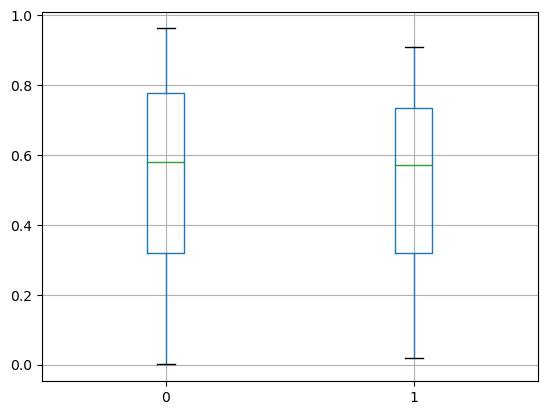

In [9]:

pd_inp.boxplot() # No outliers second feature more spread, need to standarise features, so it fits kernel, if Matern, RBA


<Axes: >

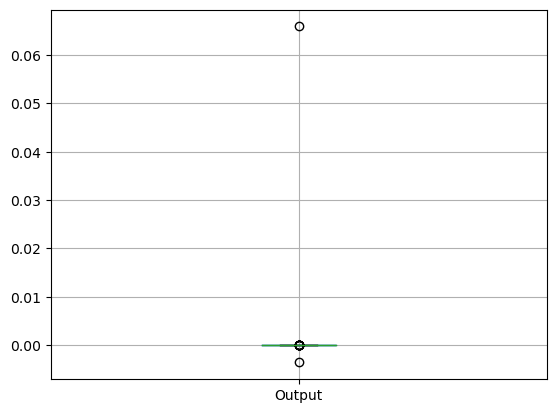

In [10]:
pd_out.boxplot() # No outliers 

In [11]:
min(f1_out)

-0.0036060626443634764

(array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>]],
       dtype=object),
 array([[<Axes: title={'center': 'Output'}>]], dtype=object))

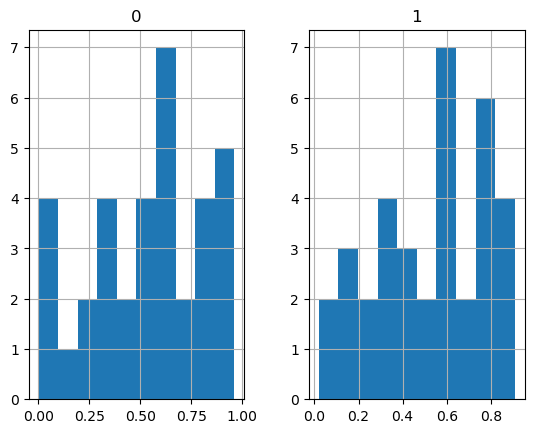

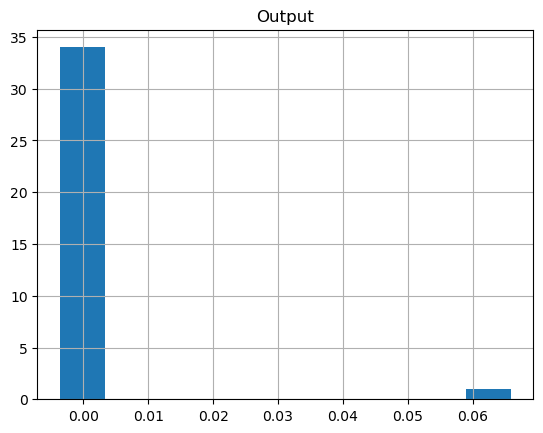

In [12]:
pd_inp.hist(), pd_out.hist()

In [13]:
skew(f1_inp),skew(f1_out)

(array([-0.26137208, -0.25849942]), 5.631754278896873)

(array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>]],
       dtype=object),
 array([[<Axes: title={'center': 'Output'}>]], dtype=object))

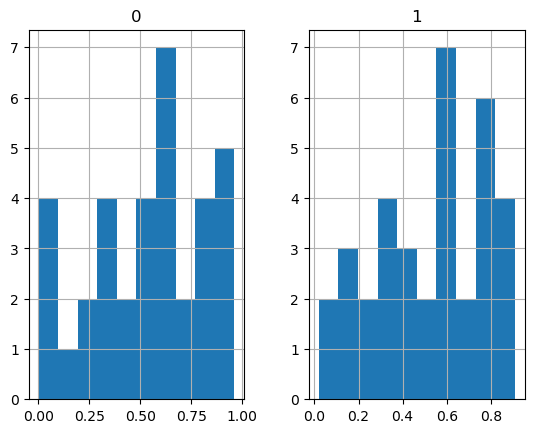

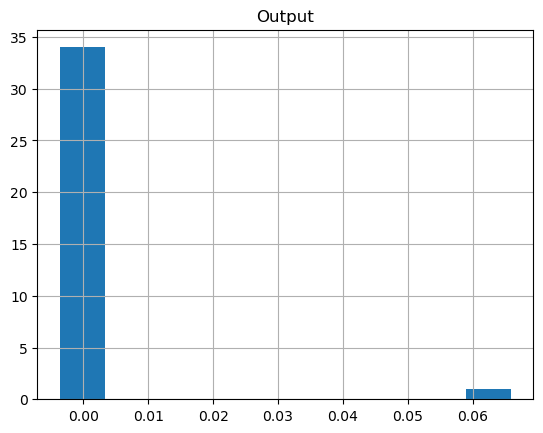

In [14]:
pd_inp.hist(), pd_out.hist()

# Input/Output Relationship Analysis 

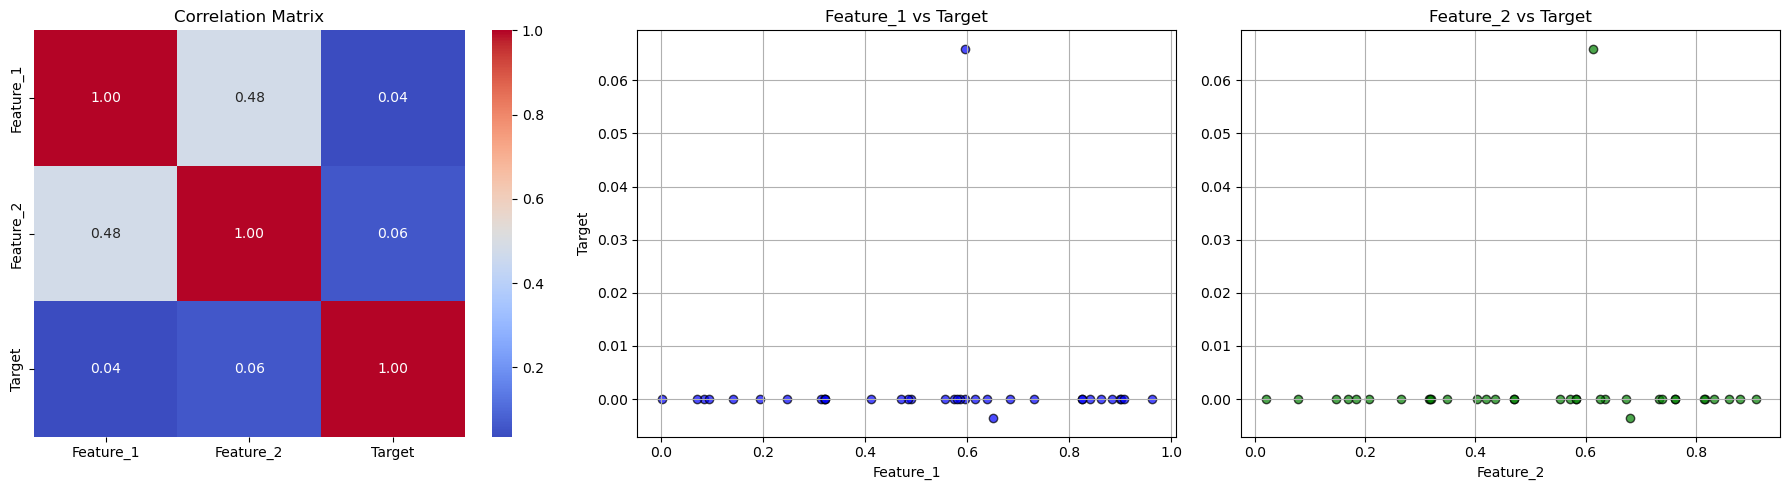

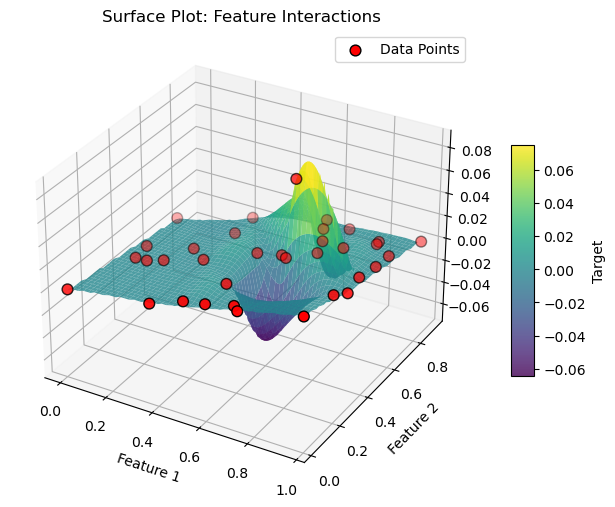

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import seaborn as sns

# Ensure f1_out is 1D
f1_out = f1_out.ravel()

# Create a figure for the inline plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# **1. Correlation Matrix**
# Convert f1_inp and f1_out to a single NumPy array for correlation
data = np.hstack((f1_inp, f1_out.reshape(-1, 1)))

# Calculate the correlation matrix
correlation_matrix = np.corrcoef(data.T)

# Plot correlation heatmap
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    cmap="coolwarm", 
    fmt=".2f",
    xticklabels=[f"Feature_{i+1}" for i in range(f1_inp.shape[1])] + ["Target"],
    yticklabels=[f"Feature_{i+1}" for i in range(f1_inp.shape[1])] + ["Target"],
    ax=axes[0]
)
axes[0].set_title("Correlation Matrix")

# **2. Scatter Plot: Feature 1 vs Target**
axes[1].scatter(f1_inp[:, 0], f1_out, color="blue", alpha=0.7, edgecolor="k")
axes[1].set_xlabel("Feature_1")
axes[1].set_ylabel("Target")
axes[1].set_title("Feature_1 vs Target")
axes[1].grid(True)

# **3. Scatter Plot: Feature 2 vs Target (if exists)**
if f1_inp.shape[1] > 1:
    axes[2].scatter(f1_inp[:, 1], f1_out, color="green", alpha=0.7, edgecolor="k")
    axes[2].set_xlabel("Feature_2")
#     axes[2].set_ylabel("Target")
    axes[2].set_title("Feature_2 vs Target")
    axes[2].grid(True)
else:
    axes[2].axis("off")
    axes[2].set_title("Feature_2 vs Target (Not Available)")

plt.tight_layout()
plt.show()





# ---------------**3D Surface Plot (Separate Block for Feature Interaction)**
#if f1_inp.shape[1] == 2:  # Ensure input is 2D
x, y = f1_inp[:, 0], f1_inp[:, 1]
z = f1_out

# Create grid points for interpolation
grid_x, grid_y = np.meshgrid(
    np.linspace(x.min(), x.max(), 100),
    np.linspace(y.min(), y.max(), 100)
)

# Interpolate the Z values for the grid
grid_z = griddata(
    (x, y), z, 
    (grid_x, grid_y), 
    method="cubic"
)

  # This visual can be good for function 1 to identify the two local minimas   
#     # Handle potential issues with NaN values in grid_z
#     if np.isnan(grid_z).any():
#         grid_z = np.nan_to_num(grid_z)  # Replace NaNs with zeros or interpolated values

# Plotting the surface
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(
    grid_x, grid_y, grid_z, 
    cmap="viridis", 
    edgecolor="none", 
    alpha=0.8
)
# Scatter points (data points)
ax.scatter(x, y, z, color='red', edgecolor='black', s=60, label="Data Points")
ax.legend(loc="best")  # Add legend for clarity

cb = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
cb.set_label("Target")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
#     ax.set_zlabel("Target")
plt.title("Surface Plot: Feature Interactions")
plt.show()
# else:
#     print("Surface plot requires exactly 2 features in the input data.")
    
    
# The red on the 3d surface plot its just to make the plot easier to see


### Inp/out relationship conclusions 

- We can see that features are very similarily correlated with target variables, we can try to remove one of them. Idea: Remove the outlier to better see a relationship between these datapoints 
- Outlier dedected on the output


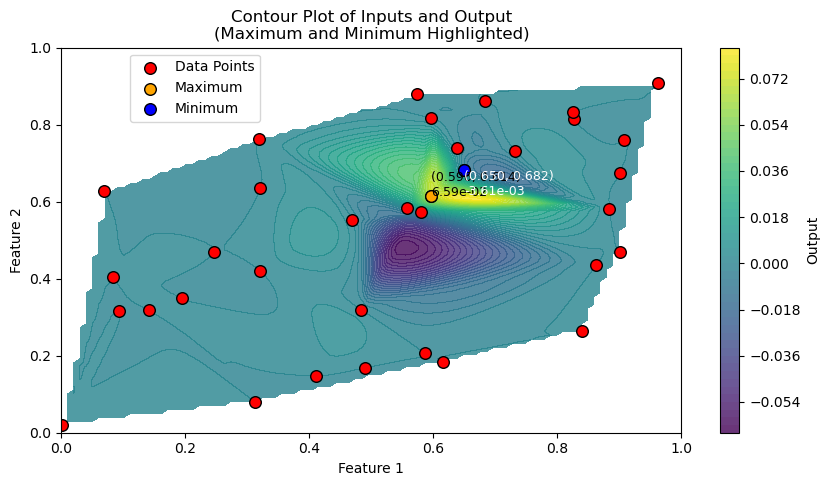

Max: 6.59e-02 at (0.5965, 0.6141)
Min: -3.61e-03 at (0.6501, 0.6815)


In [16]:

grid_x, grid_y = np.mgrid[0:1:100j, 0:1:100j]
grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')

# Identify max/min points
max_idx, min_idx = np.argmax(z), np.argmin(z)
max_x, max_y, max_z = x[max_idx], y[max_idx], z[max_idx]
min_x, min_y, min_z = x[min_idx], y[min_idx], z[min_idx]

# Plot
plt.figure(figsize=(10, 5))
plt.contourf(grid_x, grid_y, grid_z, levels=50, cmap='viridis', alpha=0.8)
plt.colorbar(label="Output")
plt.scatter(x, y, color='red', edgecolor='black', s=70, label="Data Points")
plt.scatter([max_x], [max_y], color='orange', edgecolor='black', s=70, label="Maximum")
plt.text(max_x, max_y, f"({max_x:.3f}, {max_y:.3f})\n{max_z:.2e}", fontsize=9, color='black')
plt.scatter([min_x], [min_y], color='blue', edgecolor='black', s=70, label="Minimum")
plt.text(min_x, min_y, f"({min_x:.3f}, {min_y:.3f})\n{min_z:.2e}", fontsize=9, color='white',
         ha='left', va='top')
plt.xlabel("Feature 1"), plt.ylabel("Feature 2")
plt.title("Contour Plot of Inputs and Output\n(Maximum and Minimum Highlighted)")
plt.legend()
plt.legend(loc="upper left", bbox_to_anchor=(0.1, 1.0))

plt.show()

print(f"Max: {max_z:.2e} at ({max_x:.4f}, {max_y:.4f})")
print(f"Min: {min_z:.2e} at ({min_x:.4f}, {min_y:.4f})")

## Analysing noise and uncertianty 
     
    - If skewness is low but variance is high, focus on adding a noise term to the kernel, reults from step 2 
    - Analyze residuals from a baseline model to gauge data noise (ensures an appropriate noise term in the GP).
    - Estimate signal-to-noise ratio (prevents overfitting and reflects realistic uncertainty).
    - If skewness is low but variance is high, focus on adding a noise term to the kernel, reults from step 2
    - Test after you have built the surrogate model, if there are future that just add noise and affect predictions 
    
- Aim: Follow a data-driven strategy, based on the parameters of the data, to set the inital parameter of the kernel

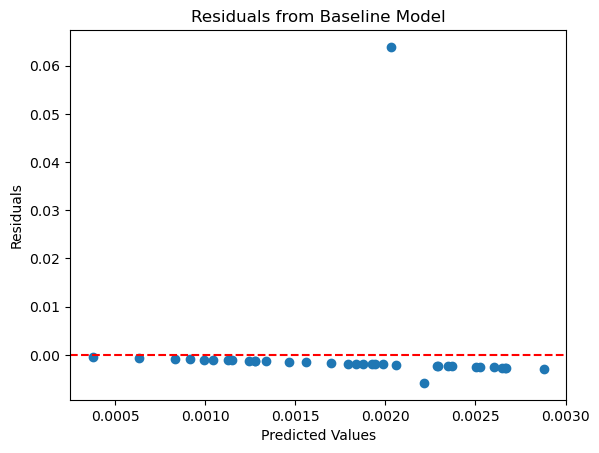

Residual Variance: 0.000
Residual Mean: 0.000


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Example Data (replace with your data)
x = f1_inp
z = f1_out  # Observed target

# Fit a baseline model (Linear Regression)
model = LinearRegression()
model.fit(x, z)
z_pred = model.predict(x)  # Predictions from the baseline model

# Residuals
residuals = z - z_pred

# Plot Residuals
plt.scatter(z_pred, residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals from Baseline Model")
plt.show()

# Print Residual Statistics
print(f"Residual Variance: {np.var(residuals, ddof=1):.3f}")
print(f"Residual Mean: {np.mean(residuals):.3f}")


In [18]:
# Signal Variance (Variance of Predictions)
signal_variance = np.var(z_pred, ddof=1)

# Residual Variance (Variance of Noise)
residual_variance = np.var(residuals, ddof=1)
residual_skewness = skew(residuals)
# Signal-to-Noise Ratio (SNR)
snr = signal_variance / residual_variance

# Display Metrics
print(f"Signal Variance: {signal_variance:.8f}")
print(f"Residual Variance (Noise): {residual_variance:.8f}")
print(f"Residual Skewnes : {residual_skewness:.8f}")
print(f"Signal-to-Noise Ratio (SNR): {snr:.8f}")


Signal Variance: 0.00000044
Residual Variance (Noise): 0.00012446
Residual Skewnes : 5.59303944
Signal-to-Noise Ratio (SNR): 0.00354109


4. **Kernel Suitability Exploration,  Bounds and Feature Ranges**  
   - Amplitdue, check variance on ouput will match kernel amplitude to output variance (captures overall scale of the data). 
   - Lengthscle check variance on input, will select length-scale according to how fast data changes (short for abrupt variation, longer for smoother patterns). 
   - Determine min-max bounds for each feature (the kernel in GP defines the relationship between features and their similarity, typically extends a bit further to avoid extraplotation, but not too far to avoid underfiting).  
  
   - Check Residual variance/ noise, when its high nise, wider bounds, low noise tigheter bounds 


In [19]:
output_variance = np.var(f1_out, ddof=1)
amplitude_init = np.sqrt(output_variance)
amplitude_init

input_variance = np.var(f1_inp, axis=0, ddof=1)
length_scale_init = np.sqrt(input_variance)
length_scale_init

# Bounds will always be the bounds of the input variable, IMPORTANT TO CHECK FOR OUTLIERS
min_bounds = np.min(f1_inp, axis=0)
max_bounds = np.max(f1_inp, axis=0)

# Extend bounds slightly (10% of range)
range_extension = 0.1 * (max_bounds - min_bounds)
extended_min_bounds = min_bounds - range_extension
extended_max_bounds = max_bounds + range_extension
amplitude_init,length_scale_init,  extended_min_bounds, extended_max_bounds

(0.011175836018393247,
 array([0.27941384, 0.2512702 ]),
 array([-0.09529029, -0.06925534]),
 array([1.05841724, 0.99718877]))

- Start with the above Amplitude but let the optimizer refine it during training
- Start with the above Lenfthscale but let the optimizer refine it during training

### --- Input/Output tranformation skiped in the first round of quering, as I did not find a way of scaling the numbers, and get a better LML from it. 

# ***************************** Output Transformation ******************************* 
- I will use Yeo-Johnson method to hanlde the heteroscedastic nature of the data, tranform outputs, and fic asymmetric skewness. 
- Reason I am using Yeo-Johnson is because we have positive and negative values as ouput 



In [20]:
# 1) Soft Cliping 
# ✅ Soft clipping smoothly scales down extreme values, 
# preserving variation while reducing outliers.
# preserves relationships between values while reducing extreme outliers.

(array([ 1.32267704e-079,  1.03307824e-046,  7.71087511e-016,
         3.34177101e-124, -3.60606264e-003, -2.15924904e-054,
        -2.08909327e-091,  2.53500115e-040,  3.60677119e-081,
         6.22985647e-048, -3.23831206e-070, -2.66554974e-065,
        -6.53456227e-084,  1.33208482e-048,  2.94212475e-055,
         8.33516100e-040, -5.03981978e-008, -2.01007653e-009,
         6.59147585e-002,  5.59549084e-011,  4.50954445e-133,
        -4.05280070e-015, -7.40958578e-118,  8.49132032e-027,
        -8.80550875e-064, -9.89621108e-052, -2.68384158e-067,
         1.19343278e-067,  6.90381175e-005,  4.65270195e-006,
         1.94836908e-040,  2.98313497e-236, -2.82664669e-053,
         4.39919787e-059, -2.40183198e-024]),
 array([ 1.32267704e-079,  1.03307824e-046,  7.71087511e-016,
         3.34177101e-124, -2.39683266e-005, -2.15924904e-054,
        -2.08909327e-091,  2.53500115e-040,  3.60677119e-081,
         6.22985647e-048, -3.23831206e-070, -2.66554974e-065,
        -6.53456227e-084

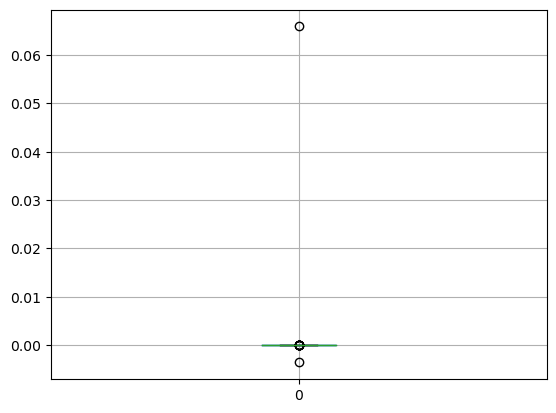

In [21]:
# 1️⃣ Clip the outliers first
max_threshold = np.percentile(f1_out, 95)  # Limit at 95th percentile
f1_out_clipped = np.clip(f1_out, -max_threshold, max_threshold)


df1 = pd.DataFrame(f1_out)
df2 = pd.DataFrame(f1_out_clipped)
df1.boxplot()

f1_out, f1_out_clipped

###### After I have observed that LML after normal tranformation I have decided to do the tranformation of the ouput depending on the LML that I am getting (in prepartion for the 5-th query )
GO TO LOCATION BEFORE THE HEBO APPLICATION 

0    8.162479e-07
dtype: float64


(<Axes: >, None)

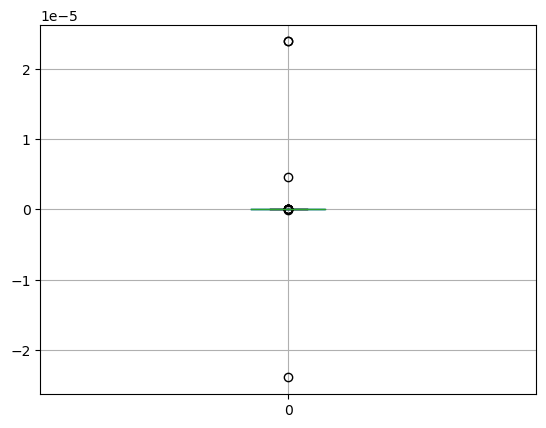

In [22]:
df2.boxplot(), print(df2.mean()) # Result of soft cliping 

In [23]:
# The above is not enough as the outliers are still dominating the dataset
# this way we will have to further scale/compress the data in order to fit 
# it to a more normal gaussian distribution

Chosen scale factor = 7.498143478474025e+52
Recovery Error = 7.792703114739563e-20
---------------------------
[ 1.32267704e-079  1.03307824e-046  7.71087511e-016  3.34177101e-124
 -2.39683266e-005 -2.15924904e-054 -2.08909327e-091  2.53500115e-040
  3.60677119e-081  6.22985647e-048 -3.23831206e-070 -2.66554974e-065
 -6.53456227e-084  1.33208482e-048  2.94212475e-055  8.33516100e-040
 -5.03981978e-008 -2.01007653e-009  2.39683266e-005  5.59549084e-011
  4.50954445e-133 -4.05280070e-015 -7.40958578e-118  8.49132032e-027
 -8.80550875e-064 -9.89621108e-052 -2.68384158e-067  1.19343278e-067
  2.39683266e-005  4.65270195e-006  1.94836908e-040  2.98313497e-236
 -2.82664669e-053  4.39919787e-059 -2.40183198e-024]
[ 9.91762222e-027  1.65558561e+001  8.76434977e+001  2.50570785e-071
 -1.11803450e+002 -1.61204483e-001 -1.56643211e-038  3.12690178e+001
  2.70440879e-028  1.37474963e+001 -2.42813284e-017 -1.99866744e-012
 -4.89970855e-031  1.22048883e+001  2.20586845e-002  3.24593066e+001
 -1.0563

<Axes: >

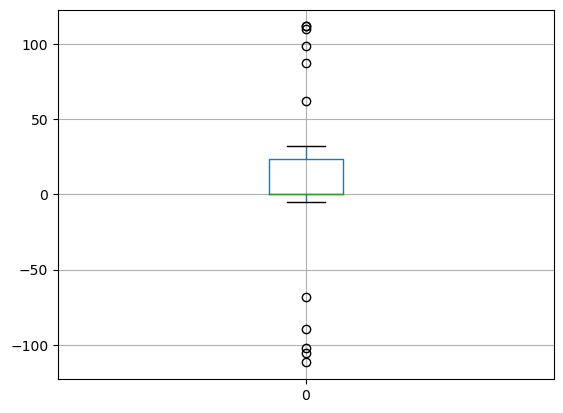

In [24]:
# Step 1: Define epsilon
epsilon = 0

# Step 2: Filter values based on epsilon
filtered_values = f1_out_clipped[np.abs(f1_out_clipped) > epsilon]

# Step 3: Define functions for scaling (arcsinh transformation)
def determine_scale(y, percentile=99, target_asinh_value=5.0):
    """
    Determines a scale factor so that the 'percentile' of |y|
    ends up around arcsinh = ±target_asinh_value.
    """
    abs_y = np.abs(y[np.abs(y) > epsilon])  # Filter using epsilon
    if len(abs_y) == 0:
        return 1.0  # Fallback in case all values are filtered out
    
    # Get the chosen percentile of the absolute values
    val = np.percentile(abs_y, percentile)
    if val == 0:
        return 1.0  # Fallback if percentile value is 0
    
    # Determine scale
    desired = np.sinh(target_asinh_value)
    scale = desired / val
    return scale

def forward_transform(y, scale):
    """
    Forward transform for GP:
      arcsinh(scale * y)
    """
    return np.arcsinh(scale * y)

def inverse_transform(y_trans, scale):
    """
    Inverse transform:
      sinh(y_trans) / scale
    """
    return np.sinh(y_trans) / scale

# Step 4: Determine scale factor
# Below what the determine_scale is doign it is compresing further the values that fall outside the 50% percentile
# target_asing_value it is how aggressive the compresion it will be. 
# Higher percentile it means less data extremes to be compressed, also means perserves relationship better when outliers exists
# Higher target_asinh_value it means more aggressive compression over the selected region 
scale_factor = determine_scale(filtered_values, percentile=50, target_asinh_value=5)
print("Chosen scale factor =", scale_factor)

# Step 5: Transform the data
f1_out_transformed = forward_transform(filtered_values, scale=scale_factor)

# Step 6: Validate inverse transformation
f1_out_recovered = inverse_transform(f1_out_transformed, scale=scale_factor)
recovery_error = np.max(np.abs(filtered_values - f1_out_recovered))
print("Recovery Error =", recovery_error)
print("---------------------------")
print(f1_out_clipped)
print(f1_out_transformed)
print(f1_out_recovered)
print("Mean Tranformed", np.mean(f1_out_transformed))

df3 = pd.DataFrame(f1_out_transformed)
df3.boxplot()

### Below I am trying to find a quartile/asinh_target values that still keeps the uniquenes of the values and does not result in memory loss
- However I have to analyse until what point is it worth it to normalize it as I am afraid that a lower percentile it might result in loss of relationship


Best combination:
Percentile: 10, Target Asinh: 1.5, Scale Factor: 2.5480904627803753e+91
Final Standard Deviation after Normalization: 1.0
Number of Unique Values: 31


array([ 0.10169415,  0.73425751,  1.32797958, -0.14501621, -1.81979527,
       -0.87659811, -0.16484321,  0.85714144,  0.07161022,  0.71080216,
       -0.57228504, -0.66681504, -0.30891276,  0.69791834,  0.56991843,
        0.8670827 , -1.76830926, -1.74140101,  1.52976285,  1.42145699,
       -0.14501621, -1.63187094, -0.14501621,  1.1172424 , -0.6960265 ,
       -0.92777534, -0.6284099 ,  0.33160891,  1.52976285,  1.51607159,
        0.85494319, -0.14501621, -0.89807868,  0.49635383, -1.45442123])

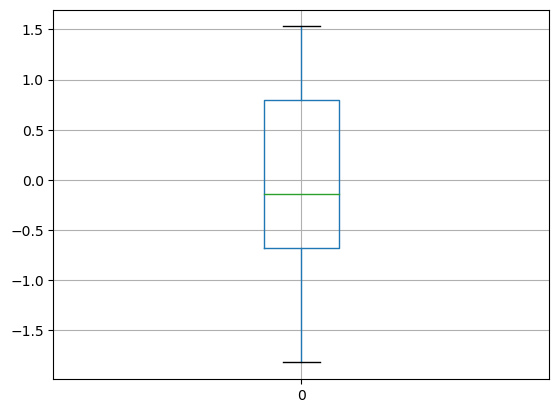

In [25]:
epsilon = 0

# Filter values based on epsilon
filtered_values = f1_out_clipped[np.abs(f1_out_clipped) > epsilon]

# Define a much larger range of values to try
percentile_values = np.arange(10, 95, 5)  # Percentiles from 10 to 90 in steps of 5
target_asinh_values = np.arange(1.0, 10.0, 0.5)  # Target asinh values from 1.0 to 9.5 in steps of 0.5

best_combination = None
best_variation = -np.inf
best_unique_values = -np.inf

# Try different combinations
for percentile in percentile_values:
    for target_asinh_value in target_asinh_values:
        scale_factor = determine_scale(filtered_values, percentile, target_asinh_value)

        # Apply transformation
        f1_out_transformed = forward_transform(filtered_values, scale_factor)

        # Normalize
        y_mean = np.mean(f1_out_transformed)
        y_std = np.std(f1_out_transformed)
        y_normalized = (f1_out_transformed - y_mean) / y_std

        # Measure variation (higher std means better variation)
        variation = np.std(y_normalized)

        # Check for uniqueness (higher number of unique values is better)
        num_unique_values = len(np.unique(np.round(y_normalized, decimals=5)))  # Round to avoid floating-point noise

        # Select best based on max variation & highest number of unique values
        if num_unique_values > best_unique_values or (num_unique_values == best_unique_values and variation > best_variation):
            best_variation = variation
            best_unique_values = num_unique_values
            best_combination = (percentile, target_asinh_value, scale_factor, y_normalized)

# Final best transformation
best_percentile, best_target_asinh, best_scale, best_y_normalized = best_combination
print("\nBest combination:")
print(f"Percentile: {best_percentile}, Target Asinh: {best_target_asinh}, Scale Factor: {best_scale}")
print(f"Final Standard Deviation after Normalization: {np.std(best_y_normalized)}")
print(f"Number of Unique Values: {len(np.unique(np.round(best_y_normalized, decimals=5)))}")

# Convert to DataFrame and visualize
df_final = pd.DataFrame(best_y_normalized)
df_final.boxplot()
df_final.mean(), df_final.std()
df_final
best_y_normalized

##### *** Normalization below to be considered as it is resulting in memory loss when quartile is high, and probarly in loss of relationship when quartile is low  ***

[ 0.10169415  0.73425751  1.32797958 -0.14501621 -1.81979527 -0.87659811
 -0.16484321  0.85714144  0.07161022  0.71080216 -0.57228504 -0.66681504
 -0.30891276  0.69791834  0.56991843  0.8670827  -1.76830926 -1.74140101
  1.52976285  1.42145699 -0.14501621 -1.63187094 -0.14501621  1.1172424
 -0.6960265  -0.92777534 -0.6284099   0.33160891  1.52976285  1.51607159
  0.85494319 -0.14501621 -0.89807868  0.49635383 -1.45442123]
<class 'numpy.ndarray'> (35,)


(0    1.903239e-17
 dtype: float64,
 0    1.014599
 dtype: float64)

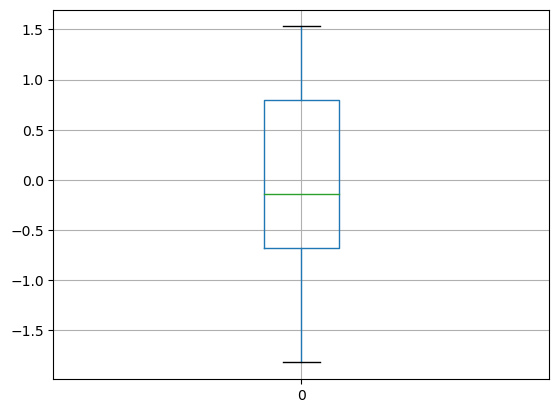

In [26]:
# Further normalisation after I noticed that further normalisation imporves the LML 

y_mean = np.mean(best_y_normalized)
y_std = np.std(best_y_normalized)

# === Step 2: Normalize the Output Manually ===
y_normalized = (best_y_normalized - y_mean) / y_std
print(y_normalized)
print(type(y_normalized), y_normalized.shape)
norm_pd = pd.DataFrame(y_normalized)
norm_pd.boxplot()
norm_pd.mean(), norm_pd.std()

### Conclusions  about output normalisation
- I am observing a wired behaivour which I suspect is because of the outliers 
- 1) When I Soft Clip + arctangent (with higher quartile) + Further normalisation: I get a result of identical values. I think this is happening because of many extreme values on the dataset, and since the arcatanget is covering or compressing just a small porportion of the dataset, it is resulting in these inner extreme values not being compressed Leading to identical values when final normalization is done
- 2) When I perform SoftClip + arctangent(lower quartile 10%) + Further normalization: I get unique values as final result. This confirm the above doubt of the presence of the extreme values or high variability of the data, which I raise above. 

    - Final thoughts:
        - I am considering to not apply a lower quartile of the arcatanget tranformation as I am afraid this it will mean applyinh too much compression on the majoirty of the data, exmp: if percentile=10%, means that 90% of the data it will be compressed, loosing too much the variability and the true relationship of the data. 
        - Higher quartile brings the problem of the last Normalizaiton, so I am considering to just remove the last step. 
        - SUM UP: Higher Quartile on the Arctangent + Remove the last step

------------------------Comparing the distribution of the ouputs on diffrent parts of the proccess--------------


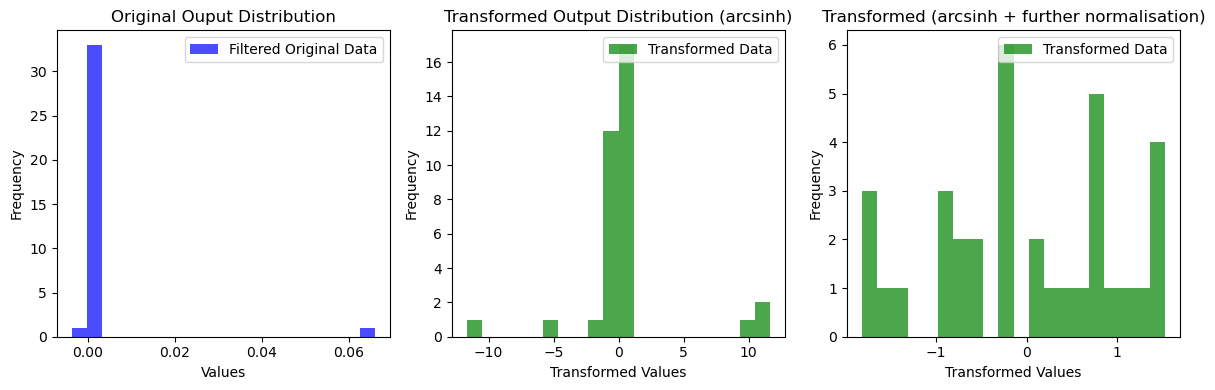

In [27]:
print("------------------------Comparing the distribution of the ouputs on diffrent parts of the proccess--------------")
# Step 7: Plot original and transformed data
plt.figure(figsize=(12, 4))

# Original data (filtered)
plt.subplot(1, 3, 1)
plt.hist(pd_out, bins=20, alpha=0.7, color='blue', label="Filtered Original Data")
plt.title("Original Ouput Distribution")
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.legend()

# Transformed data
plt.subplot(1, 3, 2)
plt.hist(f1_out_transformed, bins=20, alpha=0.7, color='green', label="Transformed Data")
plt.title("Transformed Output Distribution (arcsinh)")
plt.xlabel("Transformed Values")
plt.ylabel("Frequency")
plt.legend()

# Transformed data
plt.subplot(1, 3, 3)
plt.hist(norm_pd, bins=20, alpha=0.7, color='green', label="Transformed Data")
plt.title("Transformed (arcsinh + further normalisation)")
plt.xlabel("Transformed Values")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()

- Scale Factor: Compresses outliers by dividing the data, bringing extreme values closer to the main range.
- Target asinh Value: Defines the transformed range, helping to differentiate values by spreading smaller ones further apart.

##### Deciding if I should remove the outlier on the outputs based on Domain Knowledge about the ranges that the radiation can take. 
- I will reduce the outliers since it remains too far from the rest, it will be  ratio of the distance of the smallest values with second smallest 
- This is the only input output tranformation I will make


# ************************** Input Transformation************************** 
- #### First I will use the Kumaraswammy Cumulative Distribution Function to addres:

- Non Stationary nature of the function, the way way the patter in the data changes over the unput space, example, rapidly grows in some regions and slower in some other regions 
- I will use the CDF and finds its best parameters by minimising NLML(Negative Log Marginal Likelyhood)

In [28]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C, WhiteKernel
from scipy.optimize import minimize

from sklearn.preprocessing import MinMaxScaler

# Normalize the input
scaler = MinMaxScaler()
f1_inp_normalized = scaler.fit_transform(f1_inp)
np.std(f1_inp_normalized), np.std(f1_inp)
# skew(f1_inp_normalized), skew(f1_inp)
f1_inp_normalized
# Define the warp function as before
def kumaraswamy_warp(X, a, b):
    X_clipped = np.clip(X, 1e-6, 1 - 1e-6)
    return 1 - (1 - X_clipped ** a) ** b


In [6]:
import numpy as np
from scipy.stats import skew
from deap import base, creator, tools, algorithms
import random
from tqdm import tqdm

# Define the warp function as before
def kumaraswamy_warp(X, a, b):
    X_clipped = np.clip(X, 1e-6, 1 - 1e-6)
    return 1 - (1 - X_clipped ** a) ** b

# Objective function
def evaluate(individual):
    a, b = individual
    X_warped = kumaraswamy_warp(f1_inp_normalized, a, b)
    variance = np.var(X_warped)
    skewness = np.mean(np.abs(skew(X_warped, axis=0)))
    return (variance + skewness,)

# Setup DEAP
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_a", random.uniform, 0.01, 2.0)
toolbox.register("attr_b", random.uniform, 0.01, 2.0)
toolbox.register("individual", tools.initCycle, creator.Individual, 
                 (toolbox.attr_a, toolbox.attr_b), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Initialize population
population = toolbox.population(n=50)

# Define number of generations
NGEN = 30
CX_PROB = 0.5
MUT_PROB = 0.2

# Statistics to keep track of progress
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("avg", np.mean)

# Run Genetic Algorithm with progress bar
for gen in tqdm(range(NGEN), desc="Genetic Algorithm Generations"):
    offspring = algorithms.varAnd(population, toolbox, cxpb=CX_PROB, mutpb=MUT_PROB)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))

# Extract the best individual
best_ind = tools.selBest(population, k=1)[0]
best_a, best_b = best_ind
best_score = best_ind.fitness.values[0]

# Apply the best warp to the data
f1_inp_warped_best = kumaraswamy_warp(f1_inp_normalized, best_a, best_b)

# Calculate final variance and skewness
final_variance = np.var(f1_inp_warped_best)
final_skewness = np.mean(np.abs(skew(f1_inp_warped_best, axis=0)))

# Display the results
print("\n=== Best Kumaraswamy Parameters (GA) ===")
print(f"a = {best_a:.6f}")
print(f"b = {best_b:.6f}")
print(f"Combined Score (Variance + Skewness) = {best_score:.6f}")
print(f"Final Variance: {final_variance:.6f}")
print(f"Final Skewness: {final_skewness:.6f}")


Genetic Algorithm Generations:   0%|                                                            | 0/30 [00:00<?, ?it/s]C:\Users\alerd\AppData\Local\Temp\ipykernel_34580\3260814917.py:10: RuntimeWarning: invalid value encountered in power
  return 1 - (1 - X_clipped ** a) ** b
Genetic Algorithm Generations: 100%|███████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.78it/s]


=== Best Kumaraswamy Parameters (GA) ===
a = 0.937518
b = 0.791812
Combined Score (Variance + Skewness) = 0.143351
Final Variance: 0.102835
Final Skewness: 0.040516


In [29]:


# Define the warp function as before
def kumaraswamy_warp(X, a, b):
    X_clipped = np.clip(X, 1e-6, 1 - 1e-6)
    return 1 - (1 - X_clipped ** a) ** b


# Apply CDF on the normalized input using the given parameters
f1_inp_warped = kumaraswamy_warp(f1_inp_normalized, a=0.237299, b=0.309265)
f1_inp_warped

array([[0.36474645, 0.62623302],
       [0.4871804 , 0.77814493],
       [0.57429257, 0.60208406],
       [0.65621245, 0.33809847],
       [0.52683914, 0.56548998],
       [0.40827503, 0.26552314],
       [0.36146073, 0.20596979],
       [0.54554882, 0.73968342],
       [0.2226089 , 0.4109664 ],
       [0.70185476, 0.50518507],
       [0.7235966 , 0.44503889],
       [0.67777686, 0.42721666],
       [0.23161356, 0.36534581],
       [0.44585088, 0.2800582 ],
       [0.72480066, 0.56030552],
       [0.36553386, 0.53595683],
       [0.36525546, 0.41955798],
       [0.52059141, 0.60624822],
       [0.49844018, 0.52348228],
       [0.44294516, 0.36757052],
       [0.99106261, 0.99106261],
       [0.43614507, 0.48904667],
       [0.21051464, 0.53098048],
       [0.4984005 , 0.67857098],
       [0.26662088, 0.36678317],
       [0.49335425, 0.30486946],
       [0.50821982, 0.28977083],
       [0.73298897, 0.6250076 ],
       [0.49023745, 0.49968646],
       [0.47844937, 0.50540929],
       [0.

C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-09. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.

Best Parameters for the CDF : a=5.0, b=0.6444444444444445, Score=-1.652678616814196e-06


Second Guess - Best Parameters: a=0.1, b=0.1, Score=-1.6524935877874082e-06

Third Test:  Parameters: a=0.1, b=0.1, Score=-1.641027418617411e-06

Fourth Test: Best Parameters: a=0.1, b=0.6444444444444445, Score=-1.444854199452721e-06

Fifth Test: Best Parameters: a=3.911111111111112, b=5.0, Score=-1.4448627567918906e-06

------------Original input distribution-----------------
------------Transformed input distribution-----------------


array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>]],
      dtype=object)

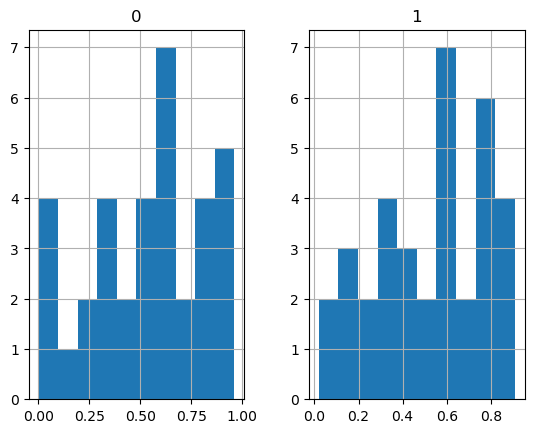

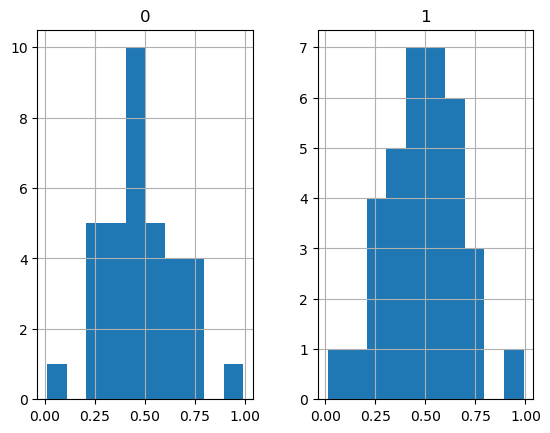

In [30]:
f1_inp_normal = pd.DataFrame(f1_inp_warped)
print("------------Original input distribution-----------------")
pd_inp.hist()

print("------------Transformed input distribution-----------------")
f1_inp_normal.hist()


# ***************************** Gaussian Process****************************


# ********************************************************************************

In [22]:
# Below I am optimising the kernel LML using random search, I have tried diffrent kernels and the below has given me so far the best LML

###### Log marginal likelihood before any transformation records 

- Log Marginal Likelihood (Original Dataset): 53.574928
- Log Marginal Likelihood (After First Query): 59.456627


- I tried to use BO (GP) to optimise the LML for the used kernel, strugling to get a better result

# Conclusion about the Kernel
- Adding noise gets a better LML 
- Making the outlier smaller imporves the LML, currently divided by 1.8


In [32]:
x_final = f1_inp_warped.copy()
y_final = y_normalized.copy() # y_normalized (this was the first tranformed output I tired)
len(x_final)
# x_final = f1_inp
# y_final = f1_out
max(y_final)

1.5297628538146946

In [34]:
import numpy as np
import warnings
from numpy.linalg import LinAlgError

from skopt import gp_minimize
from skopt.space import Real
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    ConstantKernel as C,
    ExpSineSquared,
    RBF,
    WhiteKernel
)
from scipy.stats import norm

# This kernel has been found using the random search technique, and not the bayesian optimisation
kernel = (
    C(35.5**2, (1e-10, 100))  # Final optimized constant value
    * ExpSineSquared(
        length_scale=0.0144, periodicity=0.00626,
        length_scale_bounds=(1e-3, 2),
        periodicity_bounds=(1e-5, 2)
    )
) + WhiteKernel(noise_level=1e-10, noise_level_bounds=(1e-18, 0.12))

kernel1 = (
            C(1.0) * (Matern([0.2, 0.5], nu=1.5) + RBF([0.2, 0.2], length_scale_bounds=(1e-8, 10)))
                    + WhiteKernel(noise_level=1e-10, noise_level_bounds=(1e-8, 1))
        )

gp = GaussianProcessRegressor(
    kernel=kernel1,
    normalize_y=False,  # Normalize target values before modeling
    n_restarts_optimizer=5
)

gp.fit(f1_inp, f1_out)
#location
lml = gp.log_marginal_likelihood()
print(lml)
#

115.74140509832397


C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-08. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [35]:
# 1-Final == -12 
# 1-Original == 61

# 2-Final == -16
# 2-Original == 65.38384288539513


In [18]:
from scipy.stats import shapiro, anderson, normaltest, kstest
import numpy as np



# 1️⃣ Shapiro-Wilk Test (Best for small datasets)
shapiro_stat, shapiro_p = shapiro(f1_out)
print(f"Shapiro-Wilk Test: Stat={shapiro_stat:.4f}, p-value={shapiro_p:.4f}")

# 2️⃣ Kolmogorov-Smirnov (KS) Test
ks_stat, ks_p = kstest(f1_out, 'norm', args=(np.mean(f1_out), np.std(f1_out)))
print(f"Kolmogorov-Smirnov Test: Stat={ks_stat:.4f}, p-value={ks_p:.4f}")

# 3️⃣ Anderson-Darling Test
anderson_result = anderson(f1_out, dist='norm')
print(f"Anderson-Darling Test: Stat={anderson_result.statistic:.4f}, Critical Values={anderson_result.critical_values}")

# 4️⃣ D'Agostino-K² Test (Checks Skewness & Kurtosis)
dagostino_stat, dagostino_p = normaltest(f1_out)
print(f"D'Agostino K² Test: Stat={dagostino_stat:.4f}, p-value={dagostino_p:.4f}")

# 📌 Decision Rule:
alpha = 0.05  # 5% significance level
if shapiro_p < alpha or ks_p < alpha or dagostino_p < alpha:
    print("⚠ f1_out is NOT Gaussian (Reject Normality)")
else:
    print("✅ f1_out appears Gaussian (Fail to Reject Normality)")


Shapiro-Wilk Test: Stat=0.2968, p-value=0.0000
Kolmogorov-Smirnov Test: Stat=0.5378, p-value=0.0003
Anderson-Darling Test: Stat=4.8063, Critical Values=[0.497 0.566 0.68  0.793 0.943]
D'Agostino K² Test: Stat=38.4183, p-value=0.0000
⚠ f1_out is NOT Gaussian (Reject Normality)


C:\Users\alerd\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


# Checking if soft cliping is enough but it seems data not gaussian yet 

Shapiro-Wilk Test: Stat=0.9492, p-value=0.5484
Kolmogorov-Smirnov Test: Stat=0.1459, p-value=0.8856
Anderson-Darling Test: Stat=0.3363, Critical Values=[0.497 0.566 0.68  0.793 0.943]
D'Agostino K² Test: Stat=1.0815, p-value=0.5823
✅ y_yeo_transformed appears Gaussian (Fail to Reject Normality)


C:\Users\alerd\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\alerd\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


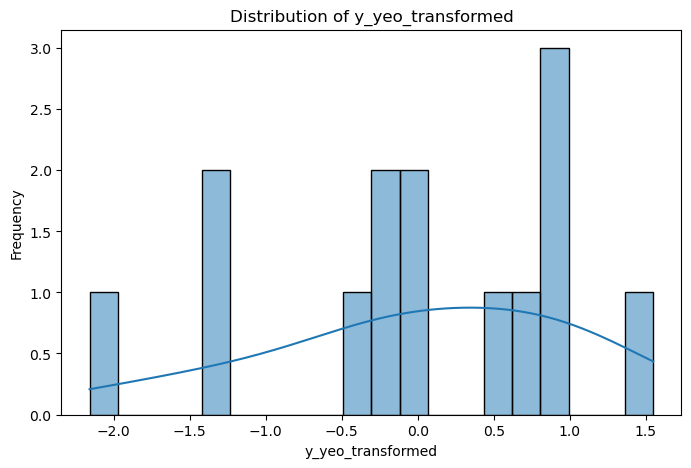

In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, anderson, normaltest, kstest


# Convert to Pandas DataFrame
df = pd.DataFrame({'y_yeo_transformed': y_yeo_transformed})

# === Normality Tests ===
# 1️⃣ Shapiro-Wilk Test
shapiro_stat, shapiro_p = shapiro(y_yeo_transformed)
print(f"Shapiro-Wilk Test: Stat={shapiro_stat:.4f}, p-value={shapiro_p:.4f}")

# 2️⃣ Kolmogorov-Smirnov (KS) Test
ks_stat, ks_p = kstest(y_yeo_transformed, 'norm', args=(np.mean(y_yeo_transformed), np.std(y_yeo_transformed)))
print(f"Kolmogorov-Smirnov Test: Stat={ks_stat:.4f}, p-value={ks_p:.4f}")

# 3️⃣ Anderson-Darling Test
anderson_result = anderson(y_yeo_transformed, dist='norm')
print(f"Anderson-Darling Test: Stat={anderson_result.statistic:.4f}, Critical Values={anderson_result.critical_values}")

# 4️⃣ D'Agostino K² Test
dagostino_stat, dagostino_p = normaltest(y_yeo_transformed)
print(f"D'Agostino K² Test: Stat={dagostino_stat:.4f}, p-value={dagostino_p:.4f}")

# 📌 Decision Rule:
alpha = 0.05  # 5% significance level
if shapiro_p < alpha or ks_p < alpha or dagostino_p < alpha:
    print("⚠ y_yeo_transformed is NOT Gaussian (Reject Normality)")
else:
    print("✅ y_yeo_transformed appears Gaussian (Fail to Reject Normality)")

# === Plot Distribution ===
plt.figure(figsize=(8, 5))
sns.histplot(df['y_yeo_transformed'], kde=True, bins=20)
plt.xlabel("y_yeo_transformed")
plt.ylabel("Frequency")
plt.title("Distribution of y_yeo_transformed")
plt.show()


# ON THE 5TH QUERY I WILL CHANGE STRATEGY OF HOW I AM TRANFORMING AND TARGETING THE AREAS OF THE ACQUISITON FUNCTION


###### Below I tried diffrent approach. Instead of training seperately a kernel, the process of training the kernel, and creating the gasussian process will be simultaneously. 
- The above aproach will be implemente din q5 because it is giving me a better lml(-1) compared to -19 on traning kernel seperately. 
- I will investigate if the iterated training has something to do with it, as we do not want the kernel to over fit. 

### Key Parameters for Exploration ↔ Exploitation
#### kappa (UCB): Typical range ~ 1 to 5.

- Larger → more exploration (search broader).
- Smaller → more exploitation (stick to known good regions).
#### xi (EI): Typical range ~ 0.0 to 0.1.

- Larger → more exploration (prefers trying uncertain areas).
- Smaller → more exploitation (focus on improving known good spots).
#### beta (Some libraries): Similar to kappa, often 1–5.

- Controls variance impact; higher → explorative.


- When the HEBOOptimizer is initialized, it first stores the raw X and y data. Since the Gaussian Process works best when the target variable is Gaussian, y_raw undergoes a Yeo-Johnson transformation using _apply_yeo_johnson(), which finds an optimal λ and transforms y_raw into y_transformed. This transformation ensures that the target variable is more Gaussian-like before training. After obtaining y_transformed, the _fit_gp() function is called to train a Gaussian Process model.

- Within _fit_gp(), X and y_transformed are converted to tensors (train_x and train_y). If a GP model (self.gp) already exists, it is reused to prevent redundant training. Otherwise, a new instance of CustomKernelGPModel is created, incorporating both the kernel and transformation. This model applies the Yeo-Johnson transformation dynamically inside its forward pass while also using a combination of Matern and RBF kernels.

- Once the GP model is instantiated, it enters training mode along with the likelihood function. The optimizer, Adam, is defined to update both the kernel and transformation parameters simultaneously by maximizing the Log Marginal Likelihood (LML). The training loop iterates, computing the negative LML (loss) and updating parameters. At each step, the transformation (λ) and kernel parameters are adjusted together to improve LML. The loop stops early if LML converges.

- Throughout training, the CustomKernelGPModel executes its forward pass, transforming train_y using Yeo-Johnson and passing it through the GP kernel to compute a posterior distribution. This ensures that λ is being optimized alongside the kernel hyperparameters, meaning the transformation and GP model evolve together.

- Once training is complete, the trained model is stored, and it is ready to be used for predictions. Since CustomKernelGPModel maintains the optimized transformation and kernel inside its structure, any future prediction will automatically apply the best transformation learned during training.

In [118]:
# pip install --upgrade scikit-learn
x_final, y_final

(array([[0.37843728, 0.6483288 ],
        [0.51343623, 0.99106261],
        [0.61911906, 0.62085376],
        [0.74582752, 0.34256532],
        [0.55989928, 0.58042197],
        [0.4254476 , 0.26854866],
        [0.3749193 , 0.20808273],
        [0.58265367, 0.80289706],
        [0.22882731, 0.41744423],
        [0.99106261, 0.5157769 ],
        [0.30882984, 0.38842555],
        [0.01181068, 0.01181068]]),
 array([-0.04577587,  0.75162904,  1.49166387, -0.36511521, -2.22189428,
        -1.2956802 , -0.3983743 ,  0.90653566, -0.08369946,  0.7220614 ,
         0.90376456, -0.36511521]))

In [39]:
from test_model import check_overfitting



Dynamic Bounds: [[0.6, 0.8], [0.8, 0.99]]
Reusing existing trained GP model.
Iteration 1: LML = -1.5448, λ = 1.0000, Next Point = [2.68951221e-09 9.99999959e-01], Predicted Output = 0.0319
Reusing existing trained GP model.


C:\Users\alerd\anaconda3\Lib\site-packages\gpytorch\models\exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Iteration 11: LML = -0.9743, λ = 1.0000, Next Point = [0.58154502 0.57471304], Predicted Output = 1.4964
Reusing existing trained GP model.
Iteration 21: LML = -0.6087, λ = 1.0000, Next Point = [0.57989435 0.57394695], Predicted Output = 2.6411
Reusing existing trained GP model.
Iteration 31: LML = -0.3580, λ = 1.0000, Next Point = [0.58035958 0.57250763], Predicted Output = 2.1021
Reusing existing trained GP model.
Iteration 41: LML = -0.2831, λ = 1.0000, Next Point = [0.58028347 0.57197436], Predicted Output = 2.2681
Reusing existing trained GP model.
Iteration 51: LML = -0.2438, λ = 1.0000, Next Point = [0.58038273 0.57258352], Predicted Output = 2.2788
Stopping early at iteration 59 (LML converged)
Training complete. Saving trained GP model inside HEBO.


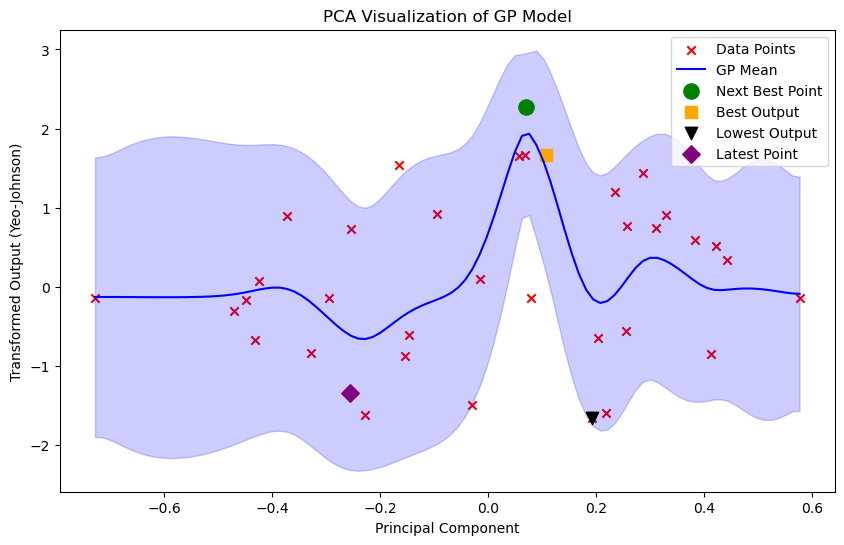

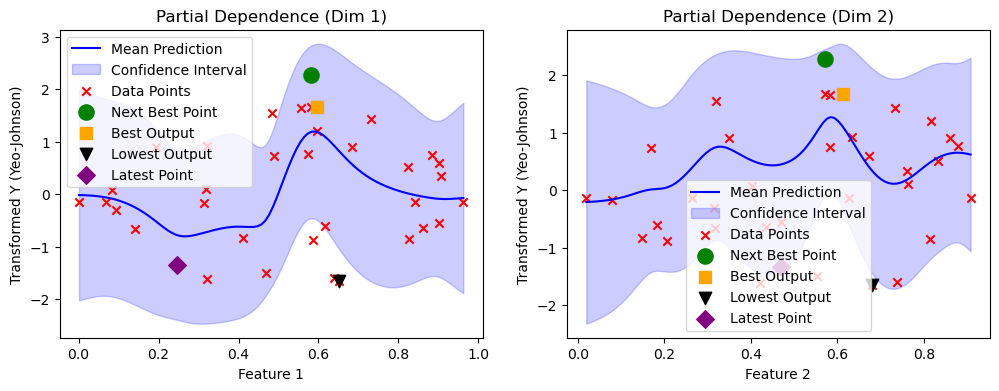

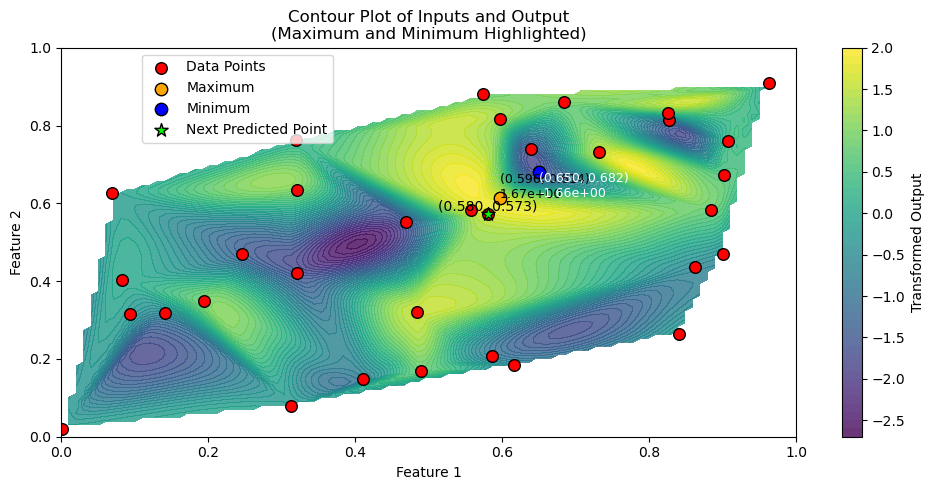

Predicted value at next best point: 2.2788
Best output point: [0.59648578 0.61407967], Value: 1.6660
Lowest output point: [0.65011406 0.68152635], Value: -1.6554
Latest point: [0.245924 0.469973], Value: -1.3418

Next best point (original space): [0.58038273 0.57258352]
Contour Max: 1.67e+00 at (0.5965, 0.6141)
Contour Min: -1.66e+00 at (0.6501, 0.6815)


<Figure size 640x480 with 0 Axes>

Predicted value at next best point: 2.2788
Best output point: [0.59648578 0.61407967], Value: 1.6660
Lowest output point: [0.65011406 0.68152635], Value: -1.6554
Latest point: [0.245924 0.469973], Value: -1.3418

Next best point (original space): [0.58038273 0.57258352]


In [43]:
import numpy as np
from sklearn.decomposition import PCA
import torch
import gpytorch
from scipy.stats import norm, yeojohnson
from math import ceil
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.core.problem import Problem

# === Define Yeo-Johnson Transformation Class ===
class YeoJohnsonTransform:
    def __init__(self, init_lambda=1.0):
        self.lmbda = torch.nn.Parameter(torch.tensor(init_lambda, requires_grad=True))
    def forward(self, y):
        y_np = y.detach().numpy()
        # Apply Yeo-Johnson correctly (only returns one value if lambda is provided)
        y_transformed = yeojohnson(y_np, lmbda=self.lmbda.item())  
        return torch.tensor(y_transformed, dtype=torch.float32)
    

# === Define Custom GPyTorch GP Model === This it will TRANSFORM AND CREATE KERNEL AT THE SAME TIME 
class CustomKernelGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(CustomKernelGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.cov_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=0.5, lengthscale_constraint=gpytorch.constraints.Interval(0.1, 0.6))
            + gpytorch.kernels.RBFKernel(lengthscale_constraint=gpytorch.constraints.Interval(0.1, 0.8))
        )
        self.transform = YeoJohnsonTransform()  # Apply Yeo-Johnson Transformation
        
    

    def forward(self, x):
        transformed_y = self.transform.forward(self.train_targets)
        mean_x = self.mean_module(x)
        covar_x = self.cov_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    def get_lml(self):
        """Compute Log Marginal Likelihood (LML) using trained parameters correctly."""
        self.eval()
        self.likelihood.eval()

        print("\nComputing LML - Kernel Parameters Before:")
        print(f"Matern Lengthscale: {self.cov_module.base_kernel.kernels[0].lengthscale.item()}")
        print(f"RBF Lengthscale: {self.cov_module.base_kernel.kernels[1].lengthscale.item()}")
        print(f"Output Scale: {self.cov_module.outputscale.item()}")

        with torch.no_grad():
            output = self(self.train_inputs[0])  # Predict using the trained GP
            lml = self.likelihood(output).log_prob(self.train_targets).sum()  # Use `.sum()` to match training LML

        print(f"Computed LML: {lml.item():.4f}")  # Should now match the training LML
        return lml.item()



# === HEBO Optimizer with GPyTorch GP ===
class HEBOOptimizer:
    def __init__(self, bounds, initial_X, initial_y, beta=2.5, xi=1.0, epsilon=0.1, random_state=None):
        self.bounds = np.array(bounds)
        self.dim = len(bounds)
        self.beta = beta
        self.xi = xi
        self.epsilon = epsilon
        self.rng = np.random.RandomState(random_state)

        # Store raw (untransformed) y values
        self.X = initial_X
        self.y_raw = initial_y  # Untransformed `y_final`

        # Apply Yeo-Johnson transformation
        self.lambda_opt, self.y_transformed = self._apply_yeo_johnson(self.y_raw)

        # Define GPyTorch likelihood and GP Model
        self.likelihood = gpytorch.likelihoods.GaussianLikelihood()
        self.gp = self._fit_gp() # THIS WILL BE OPTIMISED IN EVERY ITERATION (IT COMES FROM CUSTOMkernel at fit_gp())

    def _apply_yeo_johnson(self, y_raw):
        """Apply Yeo-Johnson transformation and return transformed y & optimal lambda"""
        y_transformed, lambda_opt = yeojohnson(y_raw)  # Automatic λ estimation
        return lambda_opt, y_transformed

    def _fit_gp(self):
        """Train the GPyTorch GP model and visualize PCA + GP predictions."""
        train_x = torch.tensor(self.X, dtype=torch.float32)
        train_y = torch.tensor(self.y_transformed, dtype=torch.float32)

        if hasattr(self, "gp") and self.gp is not None:
            print("Reusing existing trained GP model.")
            return self.gp  # Avoid reinitialization

        # Initialize GP Model
        self.gp = CustomKernelGPModel(train_x, train_y, self.likelihood)

        # Set training mode
        self.gp.train()
        self.likelihood.train()

        # Define optimizer and loss function
        optimizer = torch.optim.Adam([{'params': self.gp.parameters()}], lr=0.1)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihood, self.gp)

        prev_loss = float("inf")
        lml_values = []  # Store LML over iterations
    
    ## Below each iteration is further optimising the model we have created using gp(customkernelgpmodel)
    ## it is doing this so by leveargin the optimizer variable declared above which is using Adam
    ## optimiser.
    ##  loss.backward() → Calculates how much to change λ and kernel parameters.
    ##  optimizer.step() → Updates λ and kernel parameters to maximize LML. 
    
        for i in range(300):  
            optimizer.zero_grad()
            output = self.gp(train_x)
            loss = -mll(output, train_y)  # Maximize LML
            loss.backward()
            optimizer.step()

            # Track LML over iterations
            lml_values.append(-loss.item())

            # PREDICTING next best point every 10 iterations
            if i % 10 == 0 or i == 299:
                # Switch to evaluation mode for prediction
                self.gp.eval()
                self.likelihood.eval()

                # Get next point using acquisition function
                next_point = self.suggest_next_point().flatten()

                # Convert to tensor
                next_point_torch = torch.tensor(next_point.reshape(1, -1), dtype=torch.float32)

                # Predict GP output at next best point
                with torch.no_grad():
                    pred = self.gp(next_point_torch)
                    next_z = pred.mean.numpy()[0]

                print(f"Iteration {i+1}: LML = {-loss.item():.4f}, λ = {self.gp.transform.lmbda.item():.4f}, Next Point = {next_point}, Predicted Output = {next_z:.4f}")

            # Stop early if LML converges
            if abs(prev_loss - loss.item()) < 1e-4:
                print(f"Stopping early at iteration {i+1} (LML converged)")
                break

            prev_loss = loss.item()

        print("Training complete. Saving trained GP model inside HEBO.")

    

        # === Apply PCA to Reduce `x_final` to 1D for Visualization ===
        pca = PCA(n_components=1)
        t_data = pca.fit_transform(self.X).ravel()
        t_next = pca.transform(next_point.reshape(1, -1)).item()

        # Define grid along PCA component
        t_values = np.linspace(t_data.min(), t_data.max(), 100)
        X_plot = pca.inverse_transform(t_values.reshape(-1, 1))

        # Get GP predictions
        X_plot_torch = torch.tensor(X_plot, dtype=torch.float32)
        self.gp.eval()
        with torch.no_grad():
            pred = self.gp(X_plot_torch)
            mean_pred = pred.mean.numpy()
            std_pred = pred.stddev.numpy()

        # Find important points
        best_idx = np.argmax(self.y_transformed)  # Highest output
        low_idx = np.argmin(self.y_transformed)   # Lowest output
        latest_idx = -1  # Last added point

        # === PCA Line Plot with GP Predictions ===
        plt.figure(figsize=(10, 6))
        plt.scatter(t_data, self.y_transformed, color='red', marker='x', label='Data Points')
        plt.plot(t_values, mean_pred, label='GP Mean', color='blue')
        plt.fill_between(t_values, mean_pred - 1.96 * std_pred, mean_pred + 1.96 * std_pred, alpha=0.2, color='blue')

        # Highlight next predicted point
        plt.scatter(t_next, next_z, color='green', s=120, marker='o', label='Next Best Point')

        # Highlight best, lowest, and latest points
        plt.scatter(t_data[best_idx], self.y_transformed[best_idx], color='orange', s=80, marker='s', label='Best Output')
        plt.scatter(t_data[low_idx], self.y_transformed[low_idx], color='black', s=80, marker='v', label='Lowest Output')
        plt.scatter(t_data[latest_idx], self.y_transformed[latest_idx], color='purple', s=80, marker='D', label='Latest Point')

        plt.title('PCA Visualization of GP Model')
        plt.xlabel('Principal Component')
        plt.ylabel('Transformed Output (Yeo-Johnson)')
        plt.legend()
        plt.show()

        # === Dynamic Visualization for Each Input Dimension ===

        # =======================================
        # ... Above Code (PCA Plot) ...
        # =======================================
      
        num_dims = self.X.shape[1]  # Number of features
        baseline = np.mean(self.X, axis=0)  # Fix all other dims at their mean

        # Determine grid size: Rows based on total dimensions, 2 plots per row
        n_cols = 2
        n_rows = ceil(num_dims / n_cols)

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
        axes = axes.flatten()  # Flatten grid for easy indexing

        for dim in range(num_dims):
            ax = axes[dim]  # Select subplot for this dimension

            # 1) Create a range for the current dimension
            dim_min, dim_max = self.X[:, dim].min(), self.X[:, dim].max()
            dim_range = np.linspace(dim_min, dim_max, 100)

            # 2) Prepare baseline matrix and vary only the current dimension
            X_line = np.tile(baseline, (100, 1))
            X_line[:, dim] = dim_range

            # 3) Convert inputs to torch tensor and make predictions
            X_line_torch = torch.tensor(X_line, dtype=torch.float32)
            self.gp.eval()
            with torch.no_grad():
                pred_line = self.gp(X_line_torch)
                mean_line = pred_line.mean.numpy()
                std_line = pred_line.stddev.numpy()

            # 4) Plot predictions with confidence intervals
            ax.plot(dim_range, mean_line, color='blue', label='Mean Prediction')
            ax.fill_between(dim_range,
                            mean_line - 1.96 * std_line,
                            mean_line + 1.96 * std_line,
                            alpha=0.2, color='blue', label='Confidence Interval')

            # 5) Scatter original data points
            ax.scatter(self.X[:, dim], self.y_transformed,
                       color='red', marker='x', label='Data Points')

            # 6) Highlight key points clearly
            ax.scatter(next_point[dim], next_z, color='green', s=120,
                       marker='o', label='Next Best Point')
            ax.scatter(self.X[best_idx, dim], self.y_transformed[best_idx],
                       color='orange', s=80, marker='s', label='Best Output')
            ax.scatter(self.X[low_idx, dim], self.y_transformed[low_idx],
                       color='black', s=80, marker='v', label='Lowest Output')
            ax.scatter(self.X[latest_idx, dim], self.y_transformed[latest_idx],
                       color='purple', s=80, marker='D', label='Latest Point')

            ax.set_title(f'Partial Dependence (Dim {dim + 1})')
            ax.set_xlabel(f'Feature {dim + 1}')
            ax.set_ylabel('Transformed Y (Yeo-Johnson)')
            ax.legend()

        # === Add your provided contour plot visualization ===
        # Interpolate data for contour plot
        grid_x, grid_y = np.mgrid[0:1:100j, 0:1:100j]
        grid_z = griddata((self.X[:, 0], self.X[:, 1]), self.y_transformed,
                          (grid_x, grid_y), method='cubic')

        # Identify max/min points for contour plot
        max_idx, min_idx = np.argmax(self.y_transformed), np.argmin(self.y_transformed)
        max_x, max_y, max_z = self.X[max_idx, 0], self.X[max_idx, 1], self.y_transformed[max_idx]
        min_x, min_y, min_z = self.X[min_idx, 0], self.X[min_idx, 1], self.y_transformed[min_idx]

        # Plot contour figure separately for clarity
        plt.figure(figsize=(10, 5))
        plt.contourf(grid_x, grid_y, grid_z, levels=50, cmap='viridis', alpha=0.8)
        plt.colorbar(label="Transformed Output")

        # Data points and highlights on contour plot
        plt.scatter(self.X[:, 0], self.X[:, 1], color='red', edgecolor='black',
                    s=70, label="Data Points")
        plt.scatter(max_x, max_y, color='orange', edgecolor='black',
                    s=80, label="Maximum")
        plt.text(max_x, max_y, f"({max_x:.3f}, {max_y:.3f})\n{max_z:.2e}",
                 fontsize=9, color='black')

        plt.scatter(min_x, min_y, color='blue', edgecolor='black',
                    s=80, label="Minimum")
        plt.text(min_x, min_y, f"({min_x:.3f}, {min_y:.3f})\n{min_z:.2e}",
                 fontsize=9, color='white', ha='left', va='top')
        
        # Add Next Predicted Point to Contour Plot
        plt.scatter(next_point[0], next_point[1], color='lime', edgecolor='black',
                    s=100, marker='*', label='Next Predicted Point')
        plt.text(next_point[0], next_point[1],
                 f"({next_point[0]:.3f}, {next_point[1]:.3f})",
                 fontsize=10, color='black', ha='center', va='bottom')
        plt.legend(loc="upper left", bbox_to_anchor=(0.1, 1.0))


        plt.xlabel("Feature 1"), plt.ylabel("Feature 2")
        plt.title("Contour Plot of Inputs and Output\n(Maximum and Minimum Highlighted)")
        plt.legend(loc="upper left", bbox_to_anchor=(0.1, 1.0))
        plt.tight_layout()
        plt.show()

        # === Print Summary Clearly ===
        print(f"Predicted value at next best point: {next_z:.4f}")
        print(f"Best output point: {self.X[best_idx]}, Value: {self.y_transformed[best_idx]:.4f}")
        print(f"Lowest output point: {self.X[low_idx]}, Value: {self.y_transformed[low_idx]:.4f}")
        print(f"Latest point: {self.X[latest_idx]}, Value: {self.y_transformed[latest_idx]:.4f}")
        print("\nNext best point (original space):", next_point)

        # Also summarise the contour plot clearly:
        print(f"Contour Max: {max_z:.2e} at ({max_x:.4f}, {max_y:.4f})")
        print(f"Contour Min: {min_z:.2e} at ({min_x:.4f}, {min_y:.4f})")



        # Remove any empty subplots
        for i in range(num_dims, len(axes)):
            fig.delaxes(axes[i])

        plt.tight_layout()
        plt.show()

        # === Print Key Points ===
        print(f"Predicted value at next best point: {next_z:.4f}")
        print(f"Best output point: {self.X[best_idx]}, Value: {self.y_transformed[best_idx]:.4f}")
        print(f"Lowest output point: {self.X[low_idx]}, Value: {self.y_transformed[low_idx]:.4f}")
        print(f"Latest point: {self.X[latest_idx]}, Value: {self.y_transformed[latest_idx]:.4f}")
        print("\nNext best point (original space):", next_point)

        return self.gp  # Store trained GP in HEBO




    def _stochastic_mean(self, mu, noise_var):
        """HEBO's noise-adjusted mean"""
        return mu + self.xi * noise_var

    def _mace_optimization(self, gp):
        """Core MACE multi-acquisition optimization"""
        class MACEProblem(Problem):
            def __init__(self, gp, bounds, best, beta, xi):
                super().__init__(n_var=len(bounds), n_obj=3,
                                xl=[b[0] for b in bounds], xu=[b[1] for b in bounds])
                self.gp = gp
                self.best = best
                self.beta = beta
                self.xi = xi

            def _evaluate(self, X, out, *args, **kwargs):
                X_torch = torch.tensor(X, dtype=torch.float32)

                # Predict using GPyTorch GP
                gp.eval()
                with torch.no_grad():
                    pred = gp(X_torch)
                    mu, sigma = pred.mean.numpy(), pred.stddev.numpy()

                # Calculate acquisition functions
                sigma = np.maximum(sigma, 1e-9)  # Avoid divide by zero
                Z = (mu - self.best) / sigma
                
                ei = (mu - self.best) * norm.cdf(Z) + sigma * norm.pdf(Z)
                pi = norm.cdf(Z)
                ucb = mu + self.beta * sigma

                # Minimize [-EI, -PI, UCB]
                out["F"] = np.column_stack([-ei, -pi, ucb])

        if len(self.y_raw) == 0:
            return self._random_sample()
        
        problem = MACEProblem(self.gp, self.bounds, np.max(self.y_transformed), self.beta, self.xi)
        algorithm = NSGA2(pop_size=50, eliminate_duplicates=True)
        res = minimize(problem, algorithm, ("n_gen", 100), verbose=False)
        
        if res.X.size == 0:
            return self._random_sample()
        
        # Select best candidate from Pareto front (maximize EI)
        return res.X[np.argmax(-res.F[:, 0])]

    def _random_sample(self):
        """Generate random sample within bounds"""
        return np.array([self.rng.uniform(low, high) for (low, high) in self.bounds]).reshape(1, -1)

    def suggest_next_point(self):
        """Returns next candidate point for evaluation (maximization)"""
        # Epsilon-greedy exploration
        if self.rng.rand() < self.epsilon:
            return self._random_sample()
        
        # Fit GP with current data
        gp = self._fit_gp() # it uses the optmised gp 

        # Run MACE optimization
        candidate = self._mace_optimization(gp)
        
        # Ensure candidate is within bounds
        return np.clip(candidate, self.bounds[:, 0], self.bounds[:, 1])

    def update_data(self, X_new, y_new):
        """Update observed data with new point(s)"""
        self.X = np.vstack([self.X, np.atleast_2d(X_new)])
        self.y_raw = np.concatenate([self.y_raw, np.atleast_1d(y_new)])

        # Re-transform `y_raw` after update
        self.lambda_opt, self.y_transformed = self._apply_yeo_johnson(self.y_raw)



## Change this depending if the input is normalised/tranformed or not
def get_dynamic_bounds(f1_inp):
    return [(0, 1) if np.all((x >= 0) & (x <= 1)) else (x.min(), x.max()) for x in x_final.T]
bounds = get_dynamic_bounds(f1_inp)


print("Dynamic Bounds:", bounds1)



hebo = HEBOOptimizer(
    bounds=bounds,
    initial_X=f1_inp,
    initial_y=y_final,
    beta = 1,      # Controls exploration in UCB: Higher β explores more, Lower β exploits more
    xi = 0.2, # Increases exploration in noisy areas, expanding search range# Adjusts the stochastic mean: Higher ξ favors noisier, uncertain regions
    epsilon = 0.12 # # Exploration probabiselflity: Higher ε increases random sampling
)



In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA to reduce to 1D
pca = PCA(n_components=1)
t_data = pca.fit_transform(x_final).ravel()
t_next = pca.transform(next_point.reshape(1, -1)).item()

# Create a grid along the PCA component
t_values = np.linspace(t_data.min(), t_data.max(), 100)
X_plot = pca.inverse_transform(t_values.reshape(-1, 1))

gp = hebo._fit_gp()

# Get next best point from HEBO
next_point = hebo.suggest_next_point().flatten()
# GP predictions along the grid
mean_pred, std_pred = gp.predict(X_plot, return_std=True)

# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(t_data, y_final, color='red', marker='x', label='Data Points')
plt.plot(t_values, mean_pred, label='GP Mean')
plt.fill_between(t_values, mean_pred - 1.96 * std_pred, mean_pred + 1.96 * std_pred, alpha=0.2, label='95% Confidence Interval')
plt.scatter(t_next, gp.predict(next_point.reshape(1, -1))[0], color='green', s=100, marker='o', label='Next Best Point')
plt.title('PCA: All Features Combined into Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Output')
plt.legend()
plt.show()

print("Next best point (4D):", next_point)
print(f"Predicted value at next best point: {gp.predict(next_point.reshape(1, -1))[0]:.6f}")


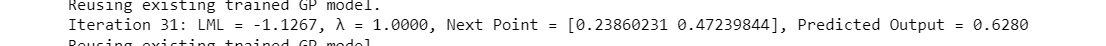

🔥 The acquisition function operates in warped space, but since the objective function expects original inputs, we must inverse-transform before querying, while ensuring the GP is updated with transformed outputs for correct Bayesian Optimization! 🔥

In [40]:
import numpy as np

def kumaraswamy_inverse_warp(Y, a, b):
    Y = np.asarray(Y)  # Ensure Y is a NumPy array
    return (1 - (1 - Y) ** (1/b)) ** (1/a)

# Input values
Y_values = np.array([0.61398724, 0.99999992])
Y_values1 = np.array([0.58046688, 0.57276951])
 
next_point_original = kumaraswamy_inverse_warp(Y_values1, a=0.237299, b=0.309265)

# Format the output correctly
formatted_output = f"{next_point_original[0]:.6f}, {next_point_original[1]:.6f}"
print("Next Point (Original Scale):", formatted_output)


Next Point (Original Scale): 0.769483, 0.756965


In [115]:
test_kernel = C(1.0) * (
    Matern([0.1, 0.2], nu=1.5) +  # Lower length scale
    RBF([0.1, 0.2], length_scale_bounds=(1e-2, 5))  # Reduce max bound
) + WhiteKernel(noise_level, noise_level_bounds=(1e-5, 0.1))  # Lower noise


NameError: name 'noise_level' is not defined

# Testing Generalisation and performance 

- Above I realised the the bounds where giving me a big change in the result, so I will test the MSE and MAE, to get the best parameters, of the Kernel.


	Lower Bound	Upper Bound	Avg MSE	Avg MAE
231	3.088844e-09	63.632653	1.972000e-07	0.000264

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (30,) and arg 1 with shape (15,).

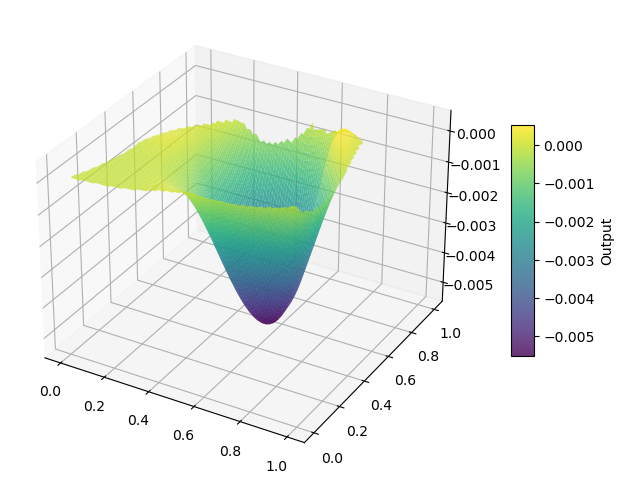

In [41]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # For 3D projection

fig = plt.figure(figsize=(10, 6), facecolor='white')
ax = fig.add_subplot(111, projection='3d')

# Surface with fine resolution and smoother appearance
surf = ax.plot_surface(
    grid_x, grid_y, grid_z,
    cmap='viridis', alpha=0.8, edgecolor='none', rcount=100, ccount=100
)

# Colorbar
cb = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
cb.set_label("Output")

# Scatter points
ax.scatter(x, y, z, color='red', edgecolor='black', s=60, label="Data Points")
#ax.scatter(max_x, max_y, max_z, color='orange', edgecolor='black', s=60, label="Maximum Point")
#ax.scatter(min_x, min_y, min_z, color='blue', edgecolor='black', s=60, label="Minimum Point")
ax.scatter(next_point[0], next_point[1], next_z, color='lime', edgecolor='black', s=60, label="Next Best Point")

# Labels
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
# ax.set_zlabel("Output")
ax.set_title("Acquisition Function Result: Next Predicted Query Point", loc="center")



# Custom viewing angle and legend
ax.view_init(elev=10, azim=110)
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()
print(f"    Next Best Point: at (x1={next_point[0]:.6f}, x2={next_point[1]:.6f})")



### Notes:
######  Problem is that I am getting lower output estimation from my actuqistion function than my maximum output
- If the uncertainty is high, this is expected behavior (good exploration).
- If your GP consistently predicts low values incorrectly, you might need to adjust the model or acquisition function.
- If the actual function values at sampled points are low, you may need better query strategies.

If σ(x) (the GP’s uncertainty) is already very high everywhere, changing β won’t fix the problem.
The issue is that σ(x) is large across the entire space, meaning the GP never becomes confident about its predictions.